<a href="https://colab.research.google.com/github/rastringer/unraveling_superposition/blob/main/superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Explorations in Superposition



In [ ]:
!pip install torchviz torch transformers torchvision

Let's make a sinple neural network of two layers and a fully-connected layer.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 784 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model and move it to GPU
model = SimpleNet().to(device)

There are various ways of building a more intuitive understanding of the model we just made. The simplest is to print its architecture:

In [8]:
print(model)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


We can also use the `torchviz` library to create a helpful visualization:

In [4]:
from torchviz import make_dot

# Same size as input data
dummy_input = torch.randn(1, 28, 28).cuda()

graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))
graph.render("Model", format="png", cleanup=True)

'Model.png'

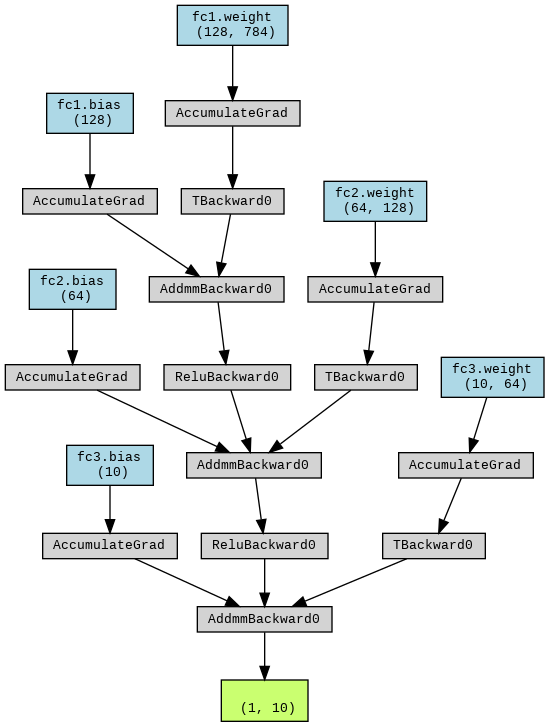

In [14]:
from IPython.display import Image, display

# Display the image in the notebook
image_path = "Model.png"
display(Image(filename=image_path))

To keep things simple and accessible on a Colab with free resources (the T4 GPU), we will use the canonical MNIST dataset of handwritten digits, 0-9.

Our training loop will run for five epochs and should complete within a few minutes on the T4.

In [10]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 5
for epoch in range(num_epochs):  # 5 epochs for demonstration
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


### 6.3 Visualizing Weight Matrices
One way to observe superposition is by visualizing the weight matrices of our layers. We can plot these as heatmaps:

In these heatmaps, look for:

Patterns or structure in the weights
Areas of high positive or negative values
Regions where weights seem to cancel each other out

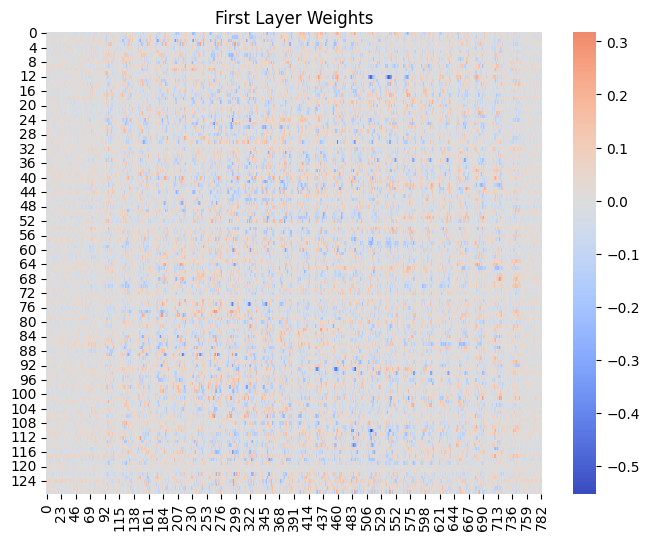

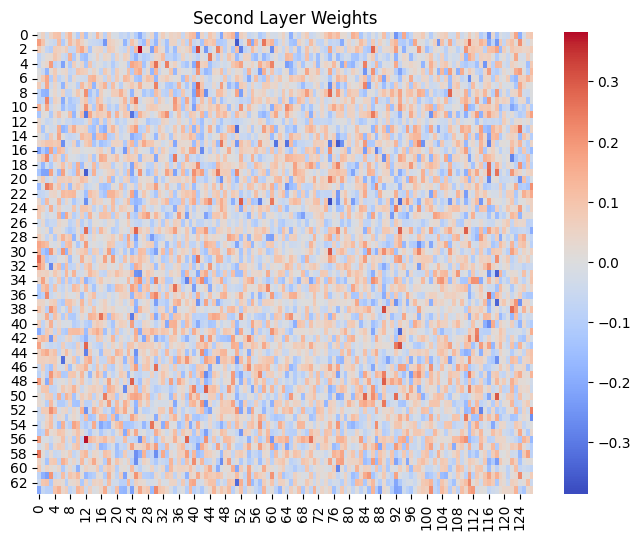

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weight_matrix(weight_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weight_matrix.detach().numpy(), cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

plot_weight_matrix(model.fc1.weight, "First Layer Weights")
plot_weight_matrix(model.fc2.weight, "Second Layer Weights")

### 6.4 Analyzing Activations
Another approach is to analyze the activations of neurons in response to different inputs:

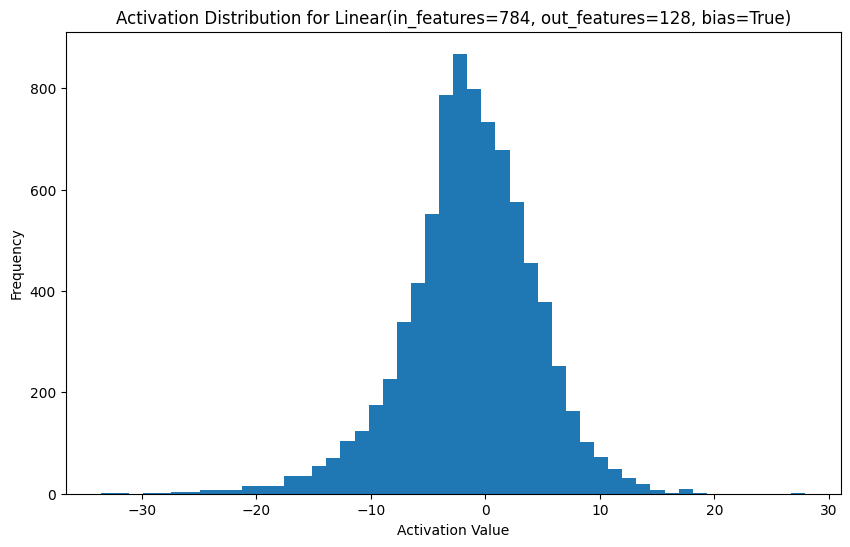

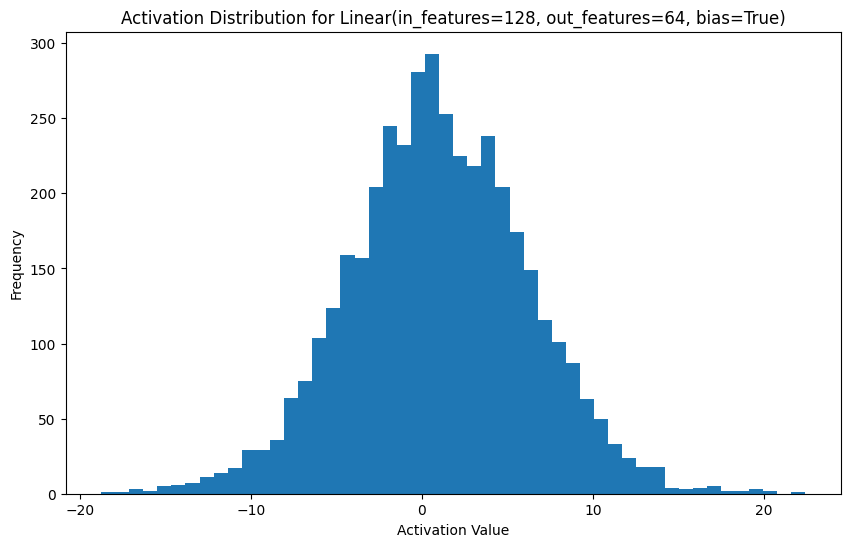

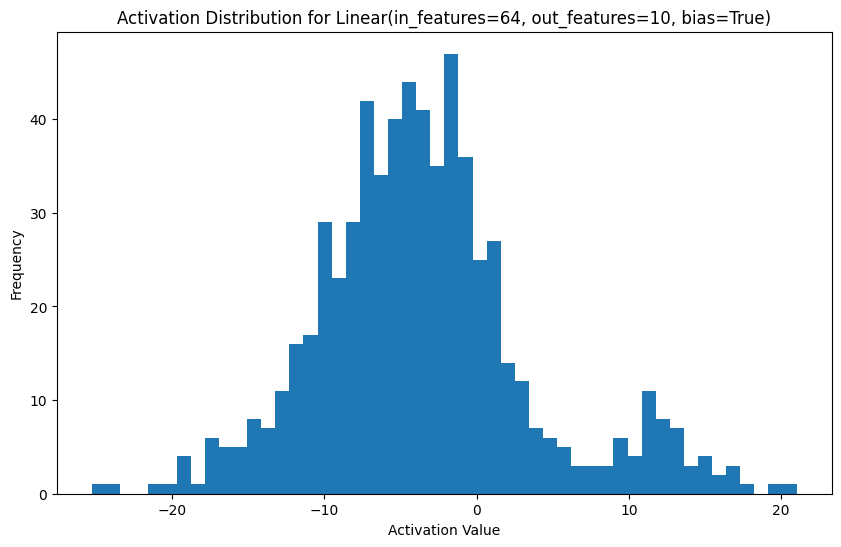

In [ ]:
def get_activations(model, input_data):
    activations = {}

    def hook_fn(module, input, output):
        activations[module] = output.detach()

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            module.register_forward_hook(hook_fn)

    model(input_data)
    return activations

# Get a batch of test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, transform=transform),
    batch_size=64, shuffle=True)
test_data, _ = next(iter(test_loader))

activations = get_activations(model, test_data.view(test_data.size(0), -1))

# Plot activation distributions
for name, activation in activations.items():
    plt.figure(figsize=(10, 6))
    plt.hist(activation.numpy().flatten(), bins=50)
    plt.title(f"Activation Distribution for {name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()

### 6.5 Measuring Superposition
To quantify superposition, we can use techniques like Singular Value Decomposition (SVD) on the weight matrices:

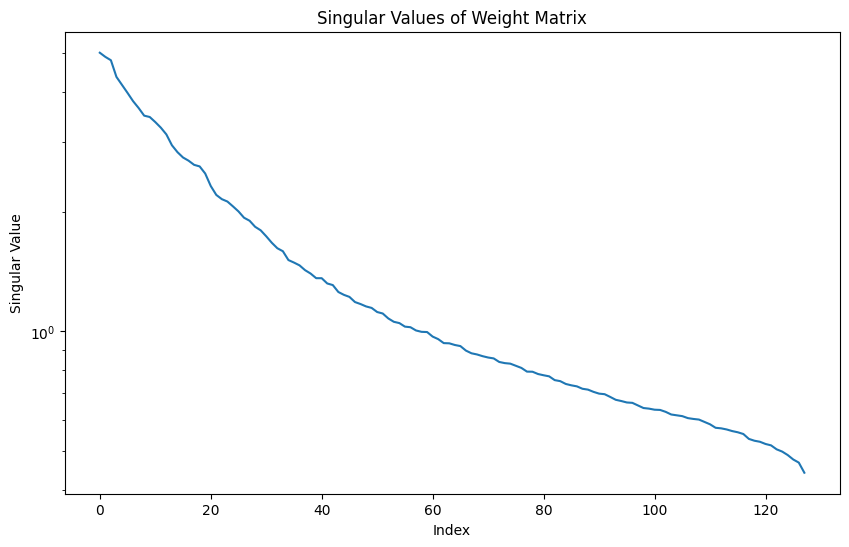

Effective Rank: 113


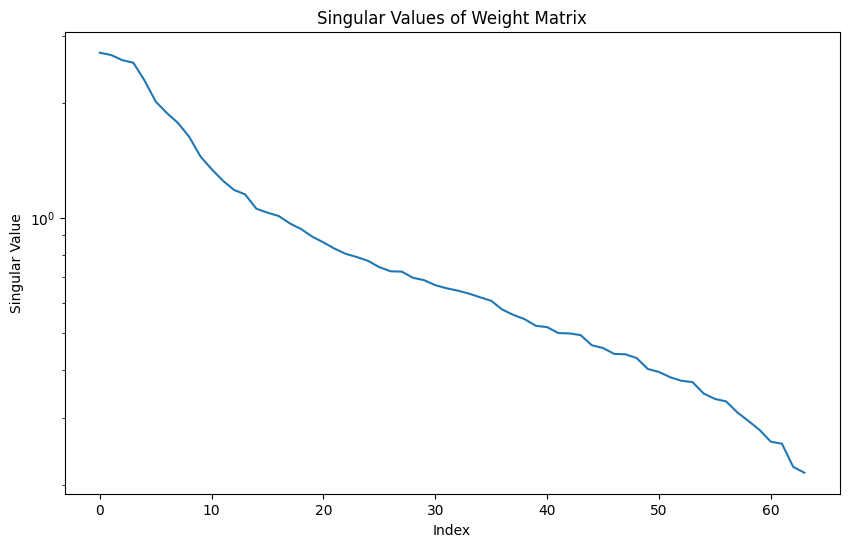

Effective Rank: 54


In [ ]:
import numpy as np

def analyze_superposition(weight_matrix):
    U, S, Vt = np.linalg.svd(weight_matrix.detach().numpy())

    # Plot singular values
    plt.figure(figsize=(10, 6))
    plt.plot(S)
    plt.title("Singular Values of Weight Matrix")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale('log')
    plt.show()

    # Calculate effective rank
    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2) / total_variance
    effective_rank = np.sum(cumulative_variance < 0.99)  # 99% of variance

    print(f"Effective Rank: {effective_rank}")

analyze_superposition(model.fc1.weight)
analyze_superposition(model.fc2.weight)

First layer (fc1):

Total neurons: 128
Effective rank: 113
Ratio: 113 / 128 ≈ 0.883 or 88.3%


Second layer (fc2):

Total neurons: 64
Effective rank: 54
Ratio: 54 / 64 ≈ 0.844 or 84.4%

In our SimpleNet model, we defined the following architecture:

```python

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
```

Let's compare the effective ranks we observed with the actual number of neurons in each layer:

First layer (fc1):

Total neurons: 128
Effective rank: 113
Ratio: 113 / 128 ≈ 0.883 or 88.3%


Second layer (fc2):

Total neurons: 64
Effective rank: 54
Ratio: 54 / 64 ≈ 0.844 or 84.4%



Interpretation:

First layer (fc1):
The effective rank of 113 compared to 128 total neurons suggests that this layer is using about 88.3% of its capacity for unique features. While there is some superposition occurring, it's relatively limited. This layer is maintaining most of its dimensions as distinct features.
Second layer (fc2):
The effective rank of 54 vs 64 total neurons indicates that this layer is using about 84.4% of its capacity for unique features, showing slightly more superposition in this layer compared to the first one. The neuron is still maintaining a high proportion of distinct features.

The effective rank gives us an idea of how many "effective features" the layer is representing. A lower effective rank compared to the actual number of neurons suggests a higher degree of superposition.

### Interpreting the Results

When looking at the results, focus on sparse activation patterns, which might indicate specialized neurons.
Compare the number of neurons to the effective rank - a large discrepancy suggests a high degree of superposition.
Observe how superposition changes across layers.
Consider how different input patterns affect the activations and whether this reveals any superposed features.

### More layers, more data: CIFAR 100

Let's explore whether larger datasets and more complex neural network architectures affect the degree of superposition.

Using device: cuda


100%|██████████| 169001437/169001437 [00:12<00:00, 13388194.69it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 1 loss: 3.2596


Validation: 100%|██████████| 79/79 [00:05<00:00, 15.33it/s]


Validation Accuracy: 27.04%


Epoch 2/10: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s]


Epoch 2 loss: 2.4965


Validation: 100%|██████████| 79/79 [00:03<00:00, 25.77it/s]


Validation Accuracy: 43.13%


Epoch 3/10: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]


Epoch 3 loss: 2.2077


Validation: 100%|██████████| 79/79 [00:04<00:00, 19.61it/s]


Validation Accuracy: 45.84%


Epoch 4/10: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 4 loss: 1.9576


Validation: 100%|██████████| 79/79 [00:03<00:00, 25.71it/s]


Validation Accuracy: 46.81%


Epoch 5/10: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 5 loss: 1.8077


Validation: 100%|██████████| 79/79 [00:03<00:00, 26.00it/s]


Validation Accuracy: 50.24%


Epoch 6/10: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s]


Epoch 6 loss: 1.7346


Validation: 100%|██████████| 79/79 [00:04<00:00, 16.83it/s]


Validation Accuracy: 49.84%


Epoch 7/10: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


Epoch 7 loss: 1.6677


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.01it/s]


Validation Accuracy: 47.09%


Epoch 8/10: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 8 loss: 1.7003


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.61it/s]


Validation Accuracy: 52.39%


Epoch 9/10: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 9 loss: 1.5110


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.51it/s]


Validation Accuracy: 54.08%


Epoch 10/10: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Epoch 10 loss: 1.3621


Validation: 100%|██████████| 79/79 [00:04<00:00, 16.38it/s]

Validation Accuracy: 56.56%
Training completed


AttributeError: 'Conv2d' object has no attribute 'replace'

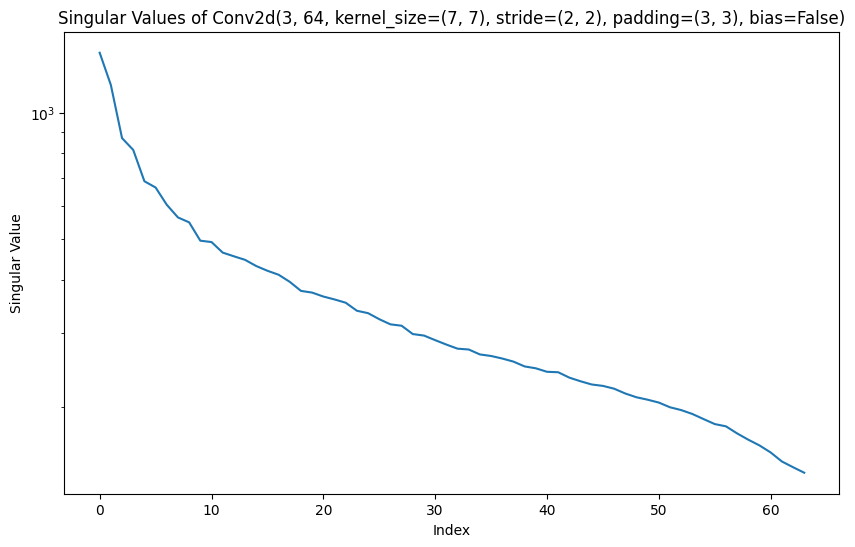

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Load pre-trained ResNet50 model and modify for CIFAR-100
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)  # 100 classes in CIFAR-100
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Validation Accuracy: {100.*correct/total:.2f}%")

print("Training completed")

# Function to get activations
def get_activations(model, loader, num_batches=10):
    activations = {}

    def hook_fn(module, input, output):
        activations[module] = output.cpu().detach()

    # Register hooks for convolutional layers
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            _ = model(inputs)

    return activations

# Get activations
activations = get_activations(model, test_loader)

# Analyze superposition
def analyze_superposition(activation, layer_name):
    # Reshape activation: (batch_size, channels, height, width) -> (channels, height*width)
    reshaped = activation.reshape(activation.shape[1], -1).numpy()

    U, S, Vt = np.linalg.svd(reshaped, full_matrices=False)

    # Plot singular values
    plt.figure(figsize=(10, 6))
    plt.plot(S)
    plt.title(f"Singular Values of {layer_name}")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale('log')
    plt.savefig(f"singular_values_{layer_name.replace('.', '_')}.png")
    plt.close()

    # Calculate effective rank
    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2) / total_variance
    effective_rank = np.sum(cumulative_variance < 0.99)  # 99% of variance

    print(f"{layer_name}:")
    print(f"  Total channels: {activation.shape[1]}")
    print(f"  Effective Rank: {effective_rank}")
    print(f"  Ratio: {effective_rank / activation.shape[1]:.2f}")
    print()

# Analyze superposition for each layer
for name, activation in activations.items():
    analyze_superposition(activation, name)

print("Analysis completed")

In [13]:
# Analyze superposition
def analyze_superposition(activation, layer):
    layer_name = str(layer)  # Convert layer to string representation
    safe_name = layer_name.replace(' ', '_').replace('.', '_').replace('(', '_').replace(')', '_')

    # Reshape activation: (batch_size, channels, height, width) -> (channels, height*width)
    reshaped = activation.reshape(activation.shape[1], -1).numpy()

    U, S, Vt = np.linalg.svd(reshaped, full_matrices=False)

    # Plot singular values
    plt.figure(figsize=(10, 6))
    plt.plot(S)
    plt.title(f"Singular Values of {layer_name}")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale('log')
    plt.savefig(f"singular_values_{safe_name}.png")
    plt.close()

    # Calculate effective rank
    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2) / total_variance
    effective_rank = np.sum(cumulative_variance < 0.99)  # 99% of variance

    print(f"{layer_name}:")
    print(f"  Total channels: {activation.shape[1]}")
    print(f"  Effective Rank: {effective_rank}")
    print(f"  Ratio: {effective_rank / activation.shape[1]:.2f}")
    print()

# Analyze superposition for each layer
for layer, activation in activations.items():
    analyze_superposition(activation, layer)

print("Analysis completed")

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False):
  Total channels: 64
  Effective Rank: 58
  Ratio: 0.91

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 48
  Ratio: 0.75

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 51
  Ratio: 0.80

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 256
  Effective Rank: 136
  Ratio: 0.53

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 256
  Effective Rank: 131
  Ratio: 0.51

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 59
  Ratio: 0.92

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 59
  Ratio: 0.92

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 256
  Effective Rank: 20

In [14]:
# Analyze superposition
def analyze_superposition(activation, layer):
    layer_name = str(layer)  # Convert layer to string representation

    # Reshape activation: (batch_size, channels, height, width) -> (channels, height*width)
    reshaped = activation.reshape(activation.shape[1], -1).numpy()

    U, S, Vt = np.linalg.svd(reshaped, full_matrices=False)

    # Plot singular values
    plt.figure(figsize=(10, 6))
    plt.plot(S)
    plt.title(f"Singular Values of {layer_name}")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale('log')
    plt.savefig(f"singular_values_{layer_name.replace('.', '_').replace(' ', '_')}.png")
    plt.close()

    # Calculate effective rank
    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2) / total_variance
    effective_rank = np.sum(cumulative_variance < 0.99)  # 99% of variance

    print(f"{layer_name}:")
    print(f"  Total channels: {activation.shape[1]}")
    print(f"  Effective Rank: {effective_rank}")
    print(f"  Ratio: {effective_rank / activation.shape[1]:.2f}")
    print()

# Analyze superposition for each layer
for layer, activation in activations.items():
    analyze_superposition(activation, layer)

print("Analysis completed")

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False):
  Total channels: 64
  Effective Rank: 58
  Ratio: 0.91

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 48
  Ratio: 0.75

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 51
  Ratio: 0.80

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 256
  Effective Rank: 136
  Ratio: 0.53

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 256
  Effective Rank: 131
  Ratio: 0.51

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 59
  Ratio: 0.92

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False):
  Total channels: 64
  Effective Rank: 59
  Ratio: 0.92

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False):
  Total channels: 256
  Effective Rank: 20

# Interpreting Superposition Analysis Results

Let's analyze a result for one single convolutional layer

```
Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False):
Total channels: 512
Effective Rank: 67
Ratio: 0.13
```

1. Layer description: `Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)`
   - This is a 2D convolutional layer
   - It takes 2048 input channels and outputs 512 channels
   - It uses a 1x1 kernel size, which is essentially a pointwise convolution

2. Total channels: 512
   - In a convolutional neural network, each channel can be thought of as a "neuron" or a feature detector
   - So this layer has 512 "neurons" or feature detectors

3. Effective Rank: 67
   - This is a measure of the number of linearly independent features or dimensions that the layer is effectively using
   - It suggests that although the layer has 512 channels, it's only using about 67 independent dimensions to represent the information

4. Ratio: 0.13 (67 / 512)
   - This ratio indicates that only about 13% of the available dimensions are being effectively utilized

## Interpretation:

1. Neurons vs. Effective Rank:
   - Neurons (Total channels): 512
   - Effective Rank: 67
   - This means that while there are 512 potential feature detectors, the layer is only using about 67 independent features

2. Superposition:
   - The large difference between the number of neurons (512) and the effective rank (67) indicates a high degree of superposition
   - This suggests that multiple features are being encoded in overlapping patterns across the 512 channels, rather than each channel representing a unique, independent feature

3. Efficiency:
   - On one hand, this shows efficient use of the network's capacity - it's representing more features than it has independent dimensions
   - On the other hand, it might indicate that the layer has more parameters than necessary for the task at hand

4. Potential implications:
   - High superposition can make the network more compact and efficient in terms of parameter usage
   - However, it can also make the network's representations more entangled and potentially harder to interpret
   - In some cases, high superposition might indicate that the layer could be compressed without significant loss of performance

5. Context in the network:
   - This is likely a layer deep in the network (given the high number of input channels)
   - Deeper layers often show more superposition as they combine and abstract features from earlier layers

In summary, this result shows a significant degree of superposition, with the layer using only about 67 effective dimensions to represent information, despite having 512 channels available. This suggests that the features learned by this layer are highly entangled and efficiently encoded, but potentially at the cost of interpretability.